<a href="https://colab.research.google.com/github/NamanJhawar-NMIMS/NLP-using-pyspark/blob/main/Assignment_2_NLP_with_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Table of Contents**

>[Table of Contents](#scrollTo=vMmBWJYsVR-B)

>[Import](#scrollTo=wIrohxemVGME)

>[Create spark Session](#scrollTo=TVZ4CwwiQIq6)

>[Load the data](#scrollTo=gmu8Er4fQN-A)

>[PrintSchema](#scrollTo=15pkHtbDQy_8)

>>[Graph: How many reviews have been adjusted](#scrollTo=1md2Oy0tQlUn)

>>[Graph: How many reviews have been adjusted](#scrollTo=c5efUkoFQ6Re)

>[Feature Preprocessing](#scrollTo=UkstH8OEFn5N)

>>[Tokenizer](#scrollTo=UAOUI_jIFtRR)

>>[StopWordsRemover](#scrollTo=HTTRPLyGFs29)

>>[CountVectorizer](#scrollTo=BPa73XKyFs0G)

>>[IDF](#scrollTo=IrjmtfvGFsxY)

>>[StringIndexer](#scrollTo=X-WI37c-GBT4)

>>[One hot encoder](#scrollTo=5Tk3mofkGEjC)

>>[Drop unnecessary columns](#scrollTo=4AGX7xB8GJk-)

>>[Column typecasting](#scrollTo=UxwXSotsGNd0)

>>[Pipeline](#scrollTo=DA7vjuPSGSim)

>[Regression](#scrollTo=JsExrBe2GV2a)

>>[Train test split](#scrollTo=TAD5FmZCGZy8)

>>[Logistic Regression](#scrollTo=guqMmjShGcjj)

>>[LinearSVC](#scrollTo=0xg-4i_2MDFg)

>>[DecisionTreeClassifier](#scrollTo=jjBSE6EyHd6t)

>>[GBTClassifier](#scrollTo=d9s23ASbHiI0)

>>[RandomForestClassifier](#scrollTo=rcwHVElFMTQK)

>[Evaluation](#scrollTo=pudWv5sOGhz2)

>>[ParamGridBuilder](#scrollTo=z9apCFQOOTX4)

>>[CrossValidator](#scrollTo=2KTvSWA_OZUW)

>>[Best Model](#scrollTo=fqyM--16P7gt)



# Import

In [8]:
try:
  from pyspark.sql import SparkSession
except:
  !pip install pyspark
  from pyspark.sql import SparkSession

try:
  import wget
except:
  !pip install wget
  import wget

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pyspark.ml.feature import Tokenizer,StopWordsRemover,CountVectorizer,IDF,StringIndexer,OneHotEncoder
from pyspark.ml.pipeline import Pipeline

from pyspark.ml.classification import LogisticRegression,LinearSVC,DecisionTreeClassifier,GBTClassifier,RandomForestClassifier,MultilayerPerceptronClassifier

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

# Create spark Session

In [4]:
session=SparkSession.builder.appName("NLP using pyspark").getOrCreate()

# Load the data
Get the data from the github location and then read it in the form of csv

In [5]:
dataset=session.read.csv(wget.download("https://raw.githubusercontent.com/NamanJhawar-NMIMS/NLP-using-pyspark/main/employee_review.csv"),header=True,inferSchema=True)

# PrintSchema

In [6]:
dataset.printSchema()

root
 |-- id: integer (nullable = true)
 |-- person_name: string (nullable = true)
 |-- nine_box_category: string (nullable = true)
 |-- feedback: string (nullable = true)
 |-- adjusted: boolean (nullable = true)
 |-- reviewed: boolean (nullable = true)



In [19]:
dataset.groupBy("adjusted").count().show()

+--------+-----+
|adjusted|count|
+--------+-----+
|    true|  124|
|   false|  754|
+--------+-----+



## Graph: How many reviews have been adjusted

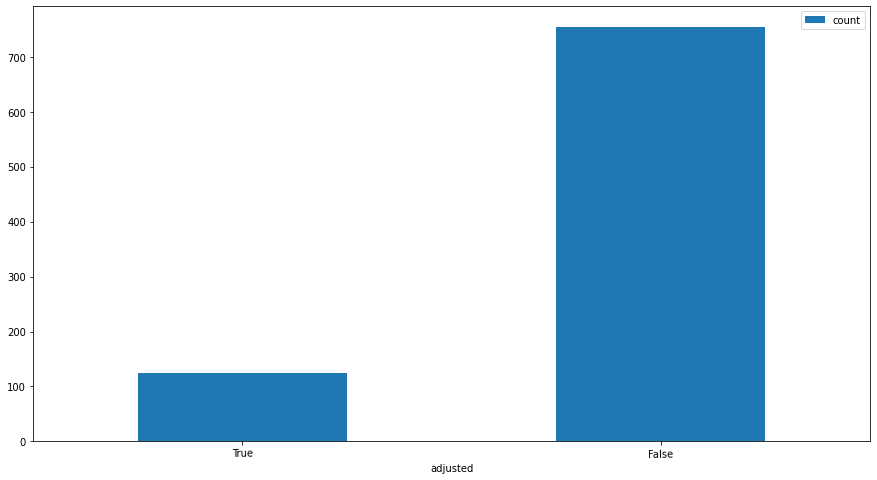

In [32]:
temp_df=dataset.groupBy("adjusted").count().toPandas()
temp_df.adjusted=temp_df.adjusted.astype('string')
temp_df.plot.bar(x='adjusted',y='count',rot=1,figsize=(15,8));

In [20]:
dataset.groupBy("reviewed").count().show()

+--------+-----+
|reviewed|count|
+--------+-----+
|    true|  245|
|   false|  633|
+--------+-----+



## Graph: How many reviews have been adjusted

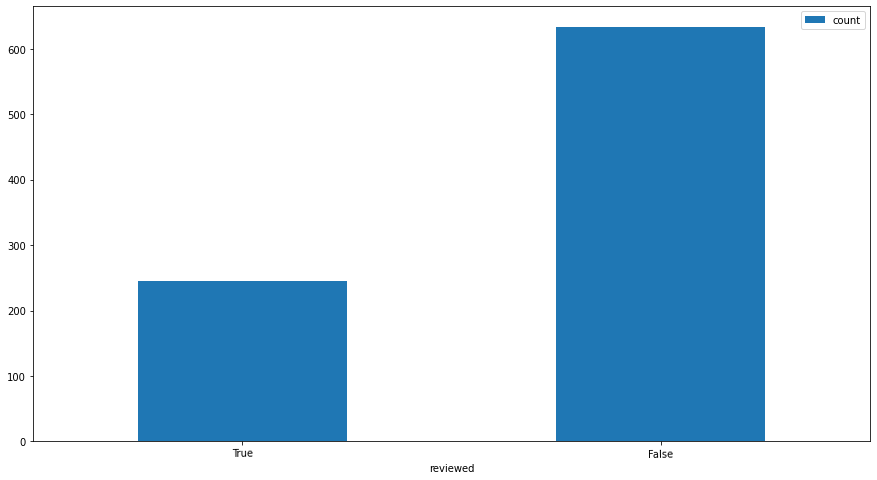

In [33]:
temp_df=dataset.groupBy("reviewed").count().toPandas()
temp_df.reviewed=temp_df.reviewed.astype('string')
temp_df.plot.bar(x='reviewed',y='count',rot=1,figsize=(15,8));

In [34]:
dataset.show(5)

+---+-----------+--------------------+--------------------+--------+--------+
| id|person_name|   nine_box_category|            feedback|adjusted|reviewed|
+---+-----------+--------------------+--------------------+--------+--------+
|  1|   John Doe|Category 1: 'Risk...|John has not prog...|   false|    true|
|  2|   John Doe|Category 1: 'Risk...|John has consiste...|   false|    true|
|  3|   John Doe|Category 1: 'Risk...|John turned in su...|   false|    true|
|  6|   John Doe|Category 1: 'Risk...|John Doe demonstr...|   false|    true|
|  7|George Gill|Category 1: 'Risk...|George gill's per...|   false|    true|
+---+-----------+--------------------+--------------------+--------+--------+
only showing top 5 rows



# Feature Preprocessing


## Tokenizer

In [35]:
tokenizer = Tokenizer(inputCol='feedback',outputCol='mytokens')


## StopWordsRemover

In [36]:
stopwords_remover = StopWordsRemover(inputCol='mytokens',outputCol='filtered_tokens')


## CountVectorizer

In [37]:
vectorizer = CountVectorizer(inputCol='filtered_tokens',outputCol='rawFeatures')


## IDF

In [38]:
idf = IDF(inputCol='rawFeatures',outputCol='vectorizedFeatures')

## StringIndexer

In [39]:

columnsTobeIndexed=["adjusted","reviewed","nine_box_category"]
stringIndexer=StringIndexer(inputCols=columnsTobeIndexed,outputCols=[string+"_indexed" for string in columnsTobeIndexed])



## One hot encoder

In [40]:
oneHotEncoder=OneHotEncoder(inputCols=stringIndexer.getOutputCols(),outputCols=[string+"_onehot" for string in stringIndexer.getOutputCols()])

## Drop unnecessary columns

In [41]:
# drop unwanted Columns from the dataset
dataset=dataset.drop(*["id",'Person_name'])

In [42]:
dataset.show(2)

+--------------------+--------------------+--------+--------+
|   nine_box_category|            feedback|adjusted|reviewed|
+--------------------+--------------------+--------+--------+
|Category 1: 'Risk...|John has not prog...|   false|    true|
|Category 1: 'Risk...|John has consiste...|   false|    true|
+--------------------+--------------------+--------+--------+
only showing top 2 rows



## Column typecasting 

In [43]:
dataset=dataset.withColumn("adjusted",dataset.adjusted.cast("string"))
dataset=dataset.withColumn("reviewed",dataset.reviewed.cast("string"))
dataset.printSchema()

root
 |-- nine_box_category: string (nullable = true)
 |-- feedback: string (nullable = true)
 |-- adjusted: string (nullable = true)
 |-- reviewed: string (nullable = true)



## Pipeline

In [44]:
myPipeline=Pipeline(stages=[tokenizer,stopwords_remover,vectorizer,idf,stringIndexer,oneHotEncoder])
dataset=myPipeline.fit(dataset).transform(dataset)

In [45]:
dataset.show()

+--------------------+--------------------+--------+--------+--------------------+--------------------+--------------------+--------------------+----------------+----------------+-------------------------+-----------------------+-----------------------+--------------------------------+
|   nine_box_category|            feedback|adjusted|reviewed|            mytokens|     filtered_tokens|         rawFeatures|  vectorizedFeatures|adjusted_indexed|reviewed_indexed|nine_box_category_indexed|adjusted_indexed_onehot|reviewed_indexed_onehot|nine_box_category_indexed_onehot|
+--------------------+--------------------+--------+--------+--------------------+--------------------+--------------------+--------------------+----------------+----------------+-------------------------+-----------------------+-----------------------+--------------------------------+
|Category 1: 'Risk...|John has not prog...|   false|    true|[john, has, not, ...|[john, progressed...|(5295,[3,8,52,79,...|(5295,[3,8,52,7

# Regression

## Train test split

In [46]:
trainDF,testDF = dataset.randomSplit((0.7,0.3),seed=42)

In [48]:
evaluator = MulticlassClassificationEvaluator(labelCol='nine_box_category_indexed',predictionCol='prediction',metricName='accuracy')
eval_dict={}
time_list=[]

## Logistic Regression

In [49]:
time1=time.time()
model = LogisticRegression(featuresCol='vectorizedFeatures',labelCol='nine_box_category_indexed')
lr_results=model.fit(trainDF).transform(testDF)
time_list.append(time.time()-time1)

eval_dict[str(model).split("_")[0]]=evaluator.evaluate(lr_results)

## LinearSVC

LinearSVC model cannot be used as it supports only 2 classes

## DecisionTreeClassifier

In [50]:
time1=time.time()

model = DecisionTreeClassifier(featuresCol='vectorizedFeatures',labelCol='nine_box_category_indexed')
DecisionTreeClassifier_results=model.fit(trainDF).transform(testDF)

time_list.append(time.time()-time1)

eval_dict[str(model).split("_")[0]]=evaluator.evaluate(DecisionTreeClassifier_results)

## GBTClassifier
Gradient Boost

GBTClassifier also supports only 2 classes

## RandomForestClassifier

In [51]:
time1=time.time()

model = RandomForestClassifier(featuresCol='vectorizedFeatures',labelCol='nine_box_category_indexed')
RandomForestClassifier_results=model.fit(trainDF).transform(testDF)
time_list.append(time.time()-time1)

eval_dict[str(model).split("_")[0]]=evaluator.evaluate(RandomForestClassifier_results)

# Evaluation

In [52]:
model_metric={'Model Name':list(eval_dict.keys()),'accuracy':list(eval_dict.values()),'Model runtime':time_list}
model_metric_df=pd.DataFrame(model_metric)
model_metric_df

,Model Name,accuracy,Model runtime
0,LogisticRegression,0.584071,7.740765
1,DecisionTreeClassifier,0.115044,5.134830
2,RandomForestClassifier,0.252212,4.329817


In [53]:
model_metric_df.sort_values('accuracy',ascending=False)

,Model Name,accuracy,Model runtime
0,LogisticRegression,0.584071,7.740765
2,RandomForestClassifier,0.252212,4.329817
1,DecisionTreeClassifier,0.115044,5.134830


## ParamGridBuilder

In [59]:
lr=LogisticRegression(featuresCol='vectorizedFeatures',labelCol='nine_box_category_indexed')
grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()

## CrossValidator

In [60]:
time1=time.time()

cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,parallelism=2)
cvModel = cv.fit(dataset)

timeTakenByCrossValidator=time.time()-time1


In [62]:
eval_dict['LogisticRegression_optimized']=(evaluator.evaluate(cvModel.transform(dataset)))


In [63]:
indexToAddAt=len(model_metric_df['Model Name'])
model_metric_df.loc[indexToAddAt,'Model Name']=list(eval_dict.keys())[-1]
model_metric_df.loc[indexToAddAt,'accuracy']=list(eval_dict.values())[-1]
model_metric_df.loc[indexToAddAt,'Model runtime']=timeTakenByCrossValidator

In [64]:
model_metric_df

,Model Name,accuracy,Model runtime
0,LogisticRegression,0.584071,7.740765
1,DecisionTreeClassifier,0.115044,5.134830
2,RandomForestClassifier,0.252212,4.329817
3,LogisticRegression_optimized,0.997722,7.107096


## Best Model

In [65]:
model_metric_df.sort_values('accuracy',ascending=False).head(1)

,Model Name,accuracy,Model runtime
3,LogisticRegression_optimized,0.997722,7.107096


**Inference**

Post optimization of the Logistic Regression model, we get an Accuracy of 99.77% with the model taking 7.1 seconds to train.